<a href="https://colab.research.google.com/github/fedhere/ABC-SN/blob/main/tutorials/Classify_with_ABCSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
os.system(f"rm -r wiserep_spectra")
os.system(f"rm -rf __MACOSX")

0

In [67]:
!unzip wiserep_spectra.zip

unzip:  cannot find or open wiserep_spectra.zip, wiserep_spectra.zip.zip or wiserep_spectra.zip.ZIP.


In [68]:
!git clone https://github.com/FoxFortino/ABC-SN.git

fatal: destination path 'ABC-SN' already exists and is not an empty directory.


In [69]:
!git clone https://github.com/fedhere/snidpy

fatal: destination path 'snidpy' already exists and is not an empty directory.


In [70]:
!pip install icecream

In [71]:

import pandas as pd
import pylab as plt
import time
import glob
import sys

import keras
# Now all existing keras imports should work
from keras import ops
from keras import layers
from keras import models

sys.path.insert(0, "/content/snidpy/sourcepy")
from apodize import *
from logwave import Logwave
sys.path.insert(0, "/content/ABC-SN/code")
from data_degrading import degrade_spectrum
import abcsn_training
import abcsn_config

# Classifying Supernova Spectra With ABC-SN

# 1. Load ABC-SN

The file `ABCSN.keras` is not hosted on GitHub because it is too large of a file. You must download it from Zenodo [here](https://zenodo.org/records/16620817). Place it in `abcsn/` and ensure that it is called `ABCSN.keras`. `ABCSN.keras` has been added to `.gitignore`.

In [72]:
abcsn = keras.models.load_model("/content/ABC-SN/abcsn/ABCSN.keras", compile=False )

# 2. Data

Using the function `load_data`, the training and test sets we used are automatically loaded. However, if you are wanting to use ABC-SN to classify new supernovae, you won't be using this function. Instead, all you need is an array of spectra with the correct shape.

Your array of spectra to classify, we'll call it `X`, should be a NumPy array with shape `(num_spectra, 1, num_wvl)` where `num_spectra` is the number of spectra and `num_wvl` is the size of each spectrum.

1. Each spectrum should be defined from 2500 to 10000 angstroms
2. Each spectrum should be normalized to mean zero and standard deviation one.
3. Each spectrum should be at a spectral resolution of R = 100. See `degrade_spectrum` in `data_degrading.py` if your spectrum is at a higher spectral resolution.

ABC-SN was originally developed for a dataset of 17 classes. During development, we reduced this to just 10. The dictionaries `sn_dict_trn` and `sn_dict_tst` (they are identical) serve to help translate the class ID from 0-16 to 0-9. We can invert this dictionary to translate class IDs in the range 0-9 to the range 0-16 (see `sn_10_to_17`). ABC-SN will predict targets in a range of 0-9 which we can translate to the range of 0-16. We do this because we already have dictionaries defined that take a class ID in the range of 0-16 and translates it into the SN subtype name.

In [73]:
cd /content/ABC-SN/abcsn

/content/ABC-SN/abcsn


In [74]:
Xtrn, Xtst, Ytrn, Ytst, num_wvl, num_classes, sn_dict_trn, sn_dict_tst, wvl = abcsn_training.load_data()

In [75]:
sn_10_to_17 = {j: i for i, j in sn_dict_trn.items()}
sn_10_to_17

{np.int64(0): np.int64(0),
 np.int64(1): np.int64(1),
 np.int64(2): np.int64(2),
 np.int64(3): np.int64(4),
 np.int64(4): np.int64(6),
 np.int64(5): np.int64(7),
 np.int64(6): np.int64(8),
 np.int64(7): np.int64(10),
 np.int64(8): np.int64(11),
 np.int64(9): np.int64(13)}

In [76]:
classes_str = [abcsn_config.SN_Stypes_str[i] for i, j in sn_dict_trn.items()]
classes_ind = [i for i, j in sn_dict_trn.items()]
classes_ind, classes_str

([np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(6),
  np.int64(7),
  np.int64(8),
  np.int64(10),
  np.int64(11),
  np.int64(13)],
 [np.str_('Ia-norm'),
  np.str_('Ia-91T'),
  np.str_('Ia-91bg'),
  np.str_('Iax'),
  np.str_('Ib-norm'),
  np.str_('Ibn'),
  np.str_('IIb'),
  np.str_('Ic-norm'),
  np.str_('Ic-broad'),
  np.str_('IIP')])

In [94]:
lw = Logwave()

In [162]:
filenames = sorted(glob.glob("/content/wiserep_spectra/*"))
filenames

['/content/wiserep_spectra/2017cfd_2007-03-31_06-49-28_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2017cfd_2017-03-18_04-48-00_HET_HET-LRS_None.dat',
 '/content/wiserep_spectra/2017cfd_2017-04-05_08-48-48_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2017cfd_2017-04-11_06-56-33_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2017cfd_2017-04-16_08-18-44_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2017cfd_2017-04-22_07-13-02_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2017cfd_2017-04-27_05-56-23_LCO2m_Spectral_None.ascii',
 '/content/wiserep_spectra/2019yvq_2020-01-15_09-09-01_P60_SEDM_ZTF.ascii',
 '/content/wiserep_spectra/2019yvq_2020-01-24_14-44-38_Keck1_LRIS_ZTF.ascii',
 '/content/wiserep_spectra/2020nlb_2020-07-06.0_LCO2m_Spectral_None.txt',
 '/content/wiserep_spectra/2020nlb_2020-07-19_LCO2m_Spectral_None.txt',
 '/content/wiserep_spectra/2020nlb_2020-07-27.0_Lick-3m_KAST_None.csv',
 '/content/wiserep_spectra/2021aefx_2021-11-28.12_Ge

In [229]:
peakmjds = {
    "2014j":56689.64,
    "2015f":57106.45,
    "2019yvq":58862.81,
    "2020nlb":59043.00,
    "2023ehl":60044.50,
    "2021aefx":59546.598
}

/content/wiserep_spectra/2017cfd_2007-03-31_06-49-28_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2017cfd_2017-03-18_04-48-00_HET_HET-LRS_None.dat




/content/wiserep_spectra/2017cfd_2017-04-05_08-48-48_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2017cfd_2017-04-11_06-56-33_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2017cfd_2017-04-16_08-18-44_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2017cfd_2017-04-22_07-13-02_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2017cfd_2017-04-27_05-56-23_LCO2m_Spectral_None.ascii




/content/wiserep_spectra/2019yvq_2020-01-15_09-09-01_P60_SEDM_ZTF.ascii






<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2086834829.py:40: SyntaxWarning: invalid escape sequence '\s'
  sep = "\s+|\t+|\s+\t+|\t+\s+"
/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2
0,3776.7,3.366000e-15,1.897000e-31
1,3802.3,4.561000e-15,9.167000e-32
2,3827.9,6.254000e-15,1.486000e-31
3,3853.4,8.136000e-15,1.115000e-31
4,3879.0,9.593000e-15,1.904000e-31


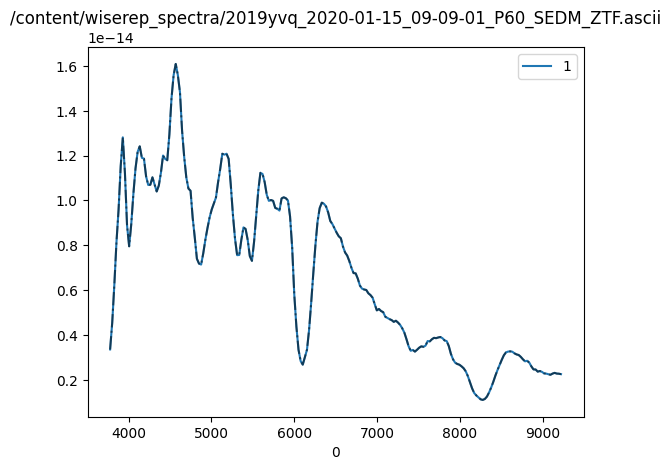

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.56902095, 0.56902095, 0.56902095, ..., 0.38272829, 0.38272829,
       0.38272829]), 'fnorm': array([ 0.        , -0.14420657, -0.13899711, ..., -0.23751504,
       -0.24390785,  0.        ]), 'fmean': np.float64(5.915423692696295e-15), 'nknot': 13}
-0.0019254291857046212
success:  /content/wiserep_spectra/2019yvq_2020-01-15_09-09-01_P60_SEDM_ZTF.ascii 2019yvq
name 2019yvq
2020-01-15
58863.0
/content/wiserep_spectra/2019yvq_2020-01-24_14-44-38_Keck1_LRIS_ZTF.ascii






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2,3,4,5,6,7
0,3064.5757,2.398200e-16,2.900480e-16,3.290820e-16,750,104.721,2.924150e+14,0.0
1,3066.5186,3.725820e-16,2.974690e-16,3.179840e-16,751,104.724,3.084350e+14,0.0
2,3068.4622,3.499620e-16,2.177040e-16,3.000200e-16,752,104.727,3.242230e+14,0.0
3,3070.4065,4.964980e-16,5.796290e-17,2.867840e-16,753,104.731,3.397250e+14,0.0
4,3072.3513,1.310920e-16,3.320130e-16,2.720120e-16,754,104.734,3.550220e+14,0.0


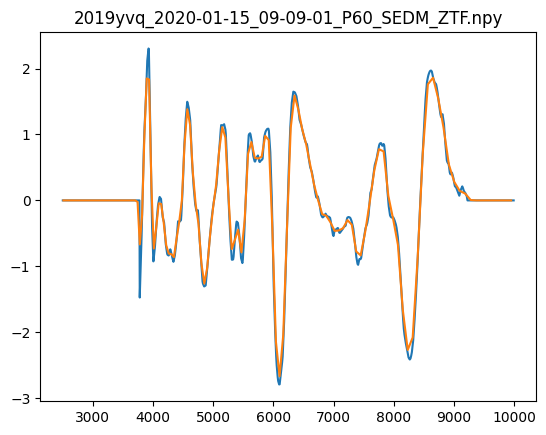

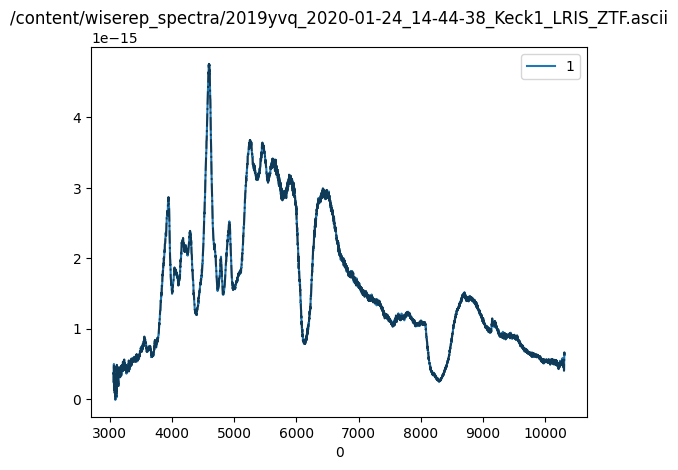

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.16958248, 0.16958248, 0.16958248, ..., 0.3872728 , 0.37690526,
       0.3751192 ]), 'fnorm': array([ 0.        , -0.46206746, -0.44957445, ..., -0.42996979,
       -0.44618155,  0.        ]), 'fmean': np.float64(1.4141791396770784e-15), 'nknot': 13}
-0.0059100596647473115
success:  /content/wiserep_spectra/2019yvq_2020-01-24_14-44-38_Keck1_LRIS_ZTF.ascii 2019yvq
name 2019yvq
2020-01-24
58872.0
/content/wiserep_spectra/2020nlb_2020-07-06.0_LCO2m_Spectral_None.txt






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3501.66,8.860400e-14
1,3505.02,9.132400e-14
2,3508.38,9.132100e-14
3,3511.75,9.180000e-14
4,3515.11,9.202400e-14


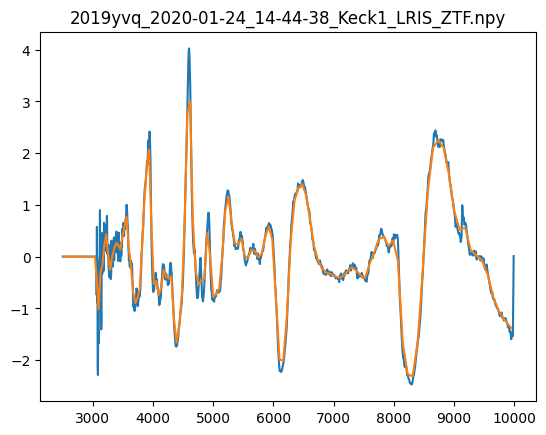

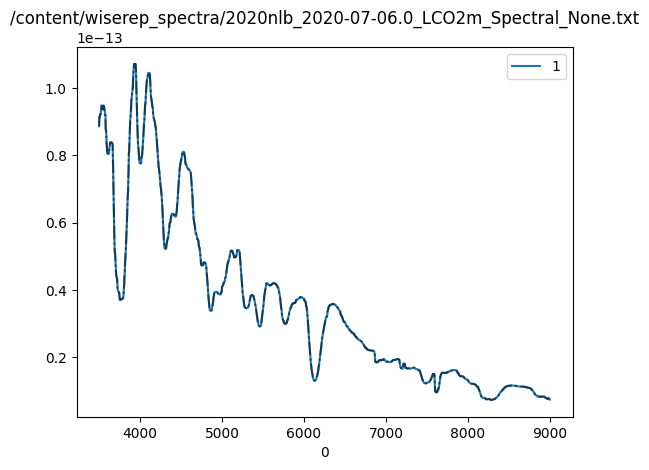

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([1.76161191, 1.76161191, 1.76161191, ..., 0.14969447, 0.14969447,
       0.14969447]), 'fnorm': array([ 0.        , -0.16306555, -0.15723935, ...,  0.10816654,
        0.11023553,  0.        ]), 'fmean': np.float64(5.0297116755746215e-14), 'nknot': 13}
0.001638357764459063
success:  /content/wiserep_spectra/2020nlb_2020-07-06.0_LCO2m_Spectral_None.txt 2020nlb
name 2020nlb
2020-07-06
59036.0
/content/wiserep_spectra/2020nlb_2020-07-19_LCO2m_Spectral_None.txt






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3304.53,1.725000e-14
1,3307.06,1.724900e-14
2,3309.59,1.754800e-14
3,3312.13,1.754700e-14
4,3314.66,1.755300e-14


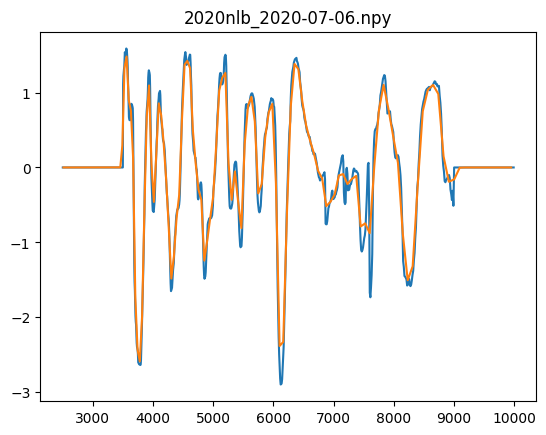

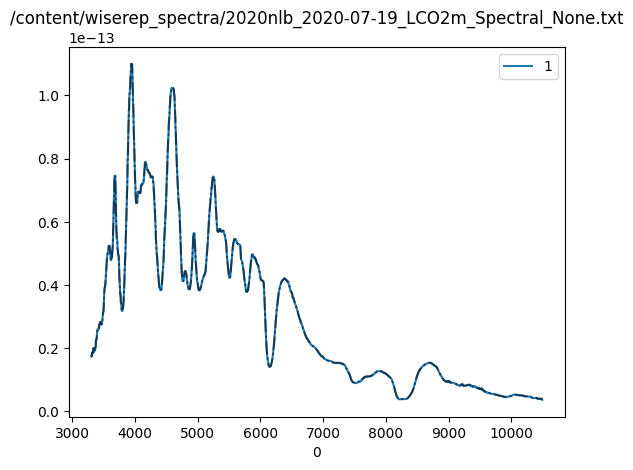

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.52397053, 0.52397053, 0.52397053, ..., 0.13972165, 0.1437423 ,
       0.14529577]), 'fnorm': array([0.        , 0.41546303, 0.39619295, ..., 0.11287552, 0.16572631,
       0.        ]), 'fmean': np.float64(3.292169861042186e-14), 'nknot': 13}
0.005418502107687653
success:  /content/wiserep_spectra/2020nlb_2020-07-19_LCO2m_Spectral_None.txt 2020nlb
name 2020nlb
2020-07-19
59049.0
/content/wiserep_spectra/2020nlb_2020-07-27.0_Lick-3m_KAST_None.csv






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2
0,3404.535,7.85583,0.822602
1,3407.069,6.59945,0.675900
2,3409.604,6.81923,0.745268
3,3412.138,8.31311,0.841889
4,3414.673,8.22799,0.859238


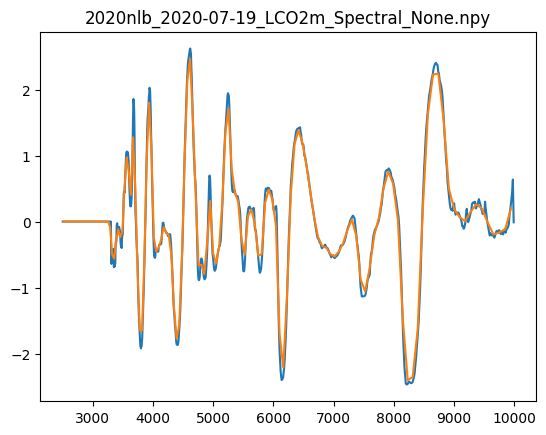

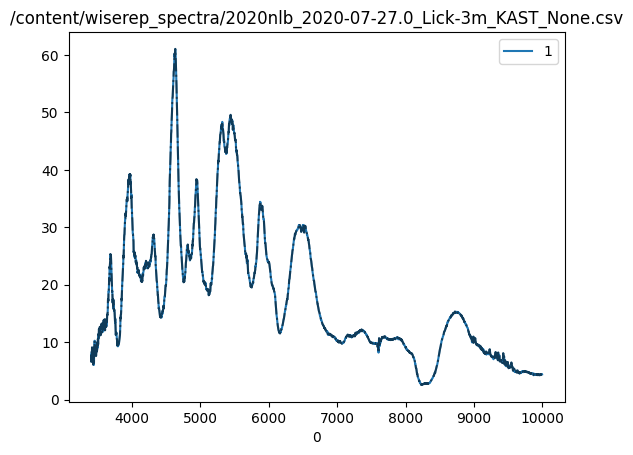

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.46531792, 0.46531792, 0.46531792, ..., 0.25844531, 0.2616012 ,
       0.26145913]), 'fnorm': array([ 0.        ,  0.28203895,  0.26969411, ..., -0.19694161,
       -0.18031082,  0.        ]), 'fmean': np.float64(16.882715224281498), 'nknot': 13}
0.002011093484220631
success:  /content/wiserep_spectra/2020nlb_2020-07-27.0_Lick-3m_KAST_None.csv 2020nlb
name 2020nlb
2020-07-27
59057.0
/content/wiserep_spectra/2021aefx_2021-11-28.12_Gemini-S_GMOS-S_None.ascii






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3655.791016,669.53284
1,3656.793865,669.51320
2,3657.796715,669.49725
3,3658.799564,669.52136
4,3659.802414,669.60420


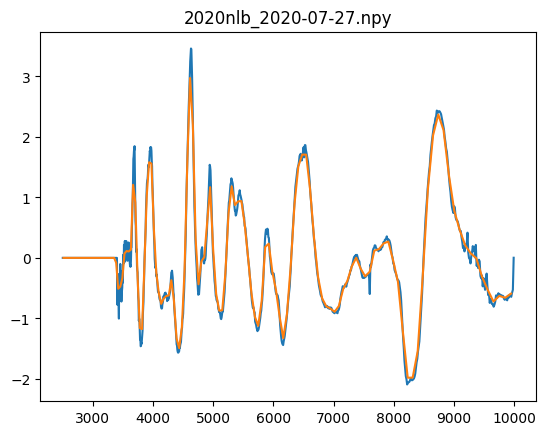

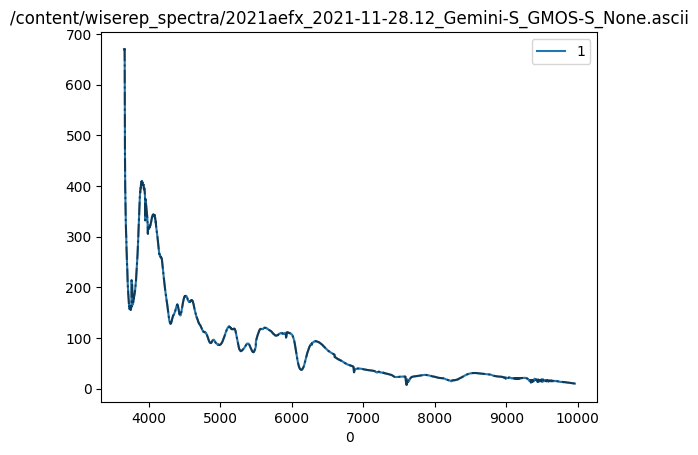

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([2.59771316, 2.59771316, 2.59771316, ..., 0.03769821, 0.03769821,
       0.03769821]), 'fnorm': array([ 0.        , -0.13073617, -0.12597684, ...,  0.30249364,
        0.33785828,  0.        ]), 'fmean': np.float64(257.7393261679685), 'nknot': 13}
0.0013728702222641775
success:  /content/wiserep_spectra/2021aefx_2021-11-28.12_Gemini-S_GMOS-S_None.ascii 2021aefx
name 2021aefx
2021-11-28
59546.0
/content/wiserep_spectra/2021aefx_2021-12-12_23-48-32.500_SALT_RSS_GSP.txt






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3492.921908,7.481073e-15
1,3493.889479,7.648040e-15
2,3494.857049,7.789473e-15
3,3495.824620,7.862785e-15
4,3496.792191,7.908996e-15


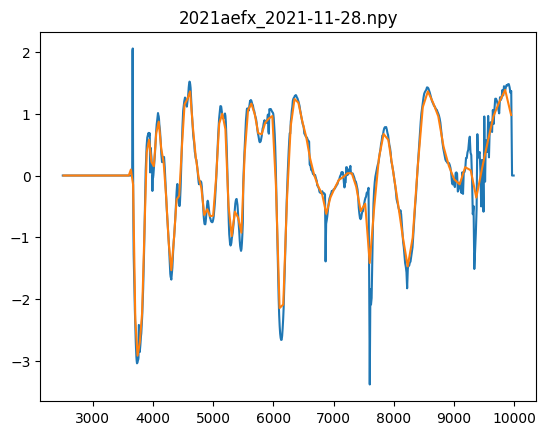

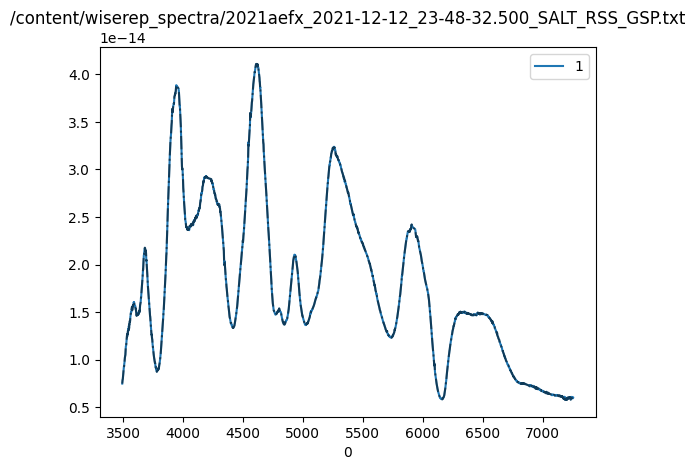

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.57203947, 0.57203947, 0.57203947, ..., 0.458236  , 0.458236  ,
       0.458236  ]), 'fnorm': array([0.        , 0.24452572, 0.23396108, ..., 0.27368596, 0.28462728,
       0.        ]), 'fmean': np.float64(1.3077896451808784e-14), 'nknot': 13}
0.00565597636289719
success:  /content/wiserep_spectra/2021aefx_2021-12-12_23-48-32.500_SALT_RSS_GSP.txt 2021aefx
name 2021aefx
2021-12-12
59560.0
/content/wiserep_spectra/SN2014J_2014-01-31_00-00-00_HCT-2m_HFOSC_None.dat






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3450.00,9.593000e-14
1,3451.27,6.445000e-14
2,3452.54,1.669000e-14
3,3453.81,4.515000e-14
4,3455.08,4.261000e-14


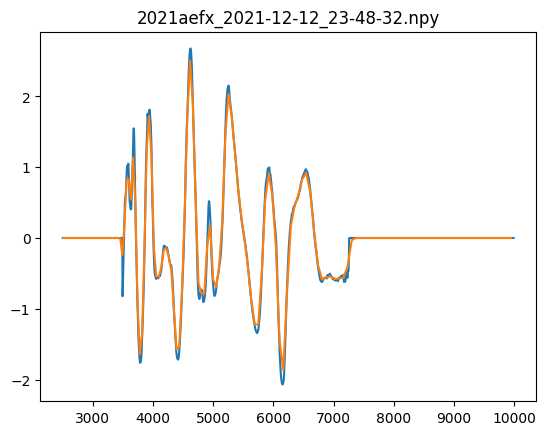

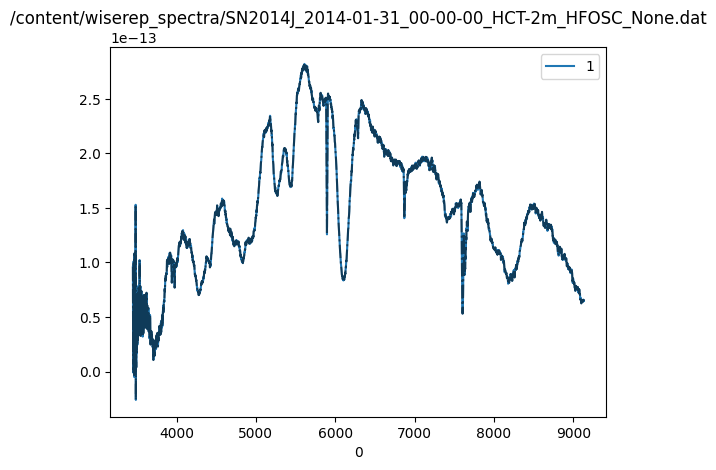

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.75279781, 0.75279781, 0.75279781, ..., 0.50843084, 0.50843084,
       0.50843084]), 'fnorm': array([ 0.        , -0.45138226, -0.43839521, ...,  0.83031461,
        0.86510321,  0.        ]), 'fmean': np.float64(1.2743129450956603e-13), 'nknot': 13}
0.007338707726790315
success:  /content/wiserep_spectra/SN2014J_2014-01-31_00-00-00_HCT-2m_HFOSC_None.dat 2014j
name 2014j
2014-01-31
56688.0
/content/wiserep_spectra/SN2014J_2014-03-07_03-15-50_Lick-3m_KAST_UCB-SNDB.flm






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2
0,3450.0,1.817060,1.36622
1,3452.0,0.733088,1.38263
2,3454.0,1.468450,1.39101
3,3456.0,1.691120,1.39391
4,3458.0,0.180721,1.40104


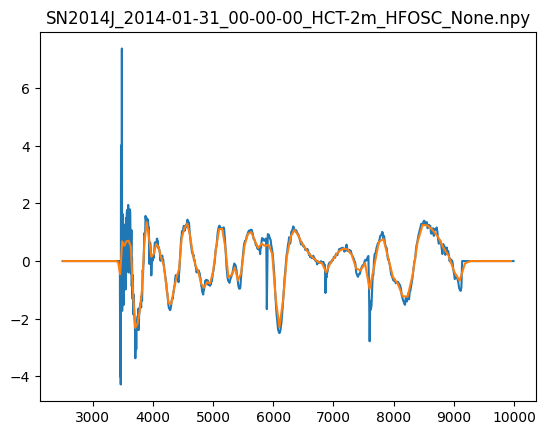

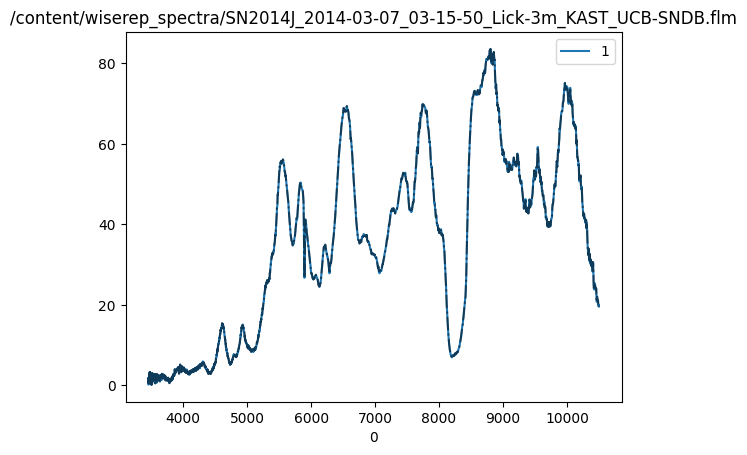

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.07849549, 0.07849549, 0.07849549, ..., 3.18688844, 3.17689462,
       3.20894689]), 'fnorm': array([ 0.        , -0.08245534, -0.07937307, ..., -0.09527971,
       -0.11112614,  0.        ]), 'fmean': np.float64(23.148591263178776), 'nknot': 13}
-0.0024616835996722967
success:  /content/wiserep_spectra/SN2014J_2014-03-07_03-15-50_Lick-3m_KAST_UCB-SNDB.flm 2014j
name 2014j
2014-03-07
56723.0
/content/wiserep_spectra/SN2014J_2014-03-13_00-00-00_HCT-2m_HFOSC_None.dat






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3450.00,-2.695000e-15
1,3451.27,2.544000e-15
2,3452.54,4.759000e-15
3,3453.81,6.442000e-15
4,3455.08,9.705000e-15


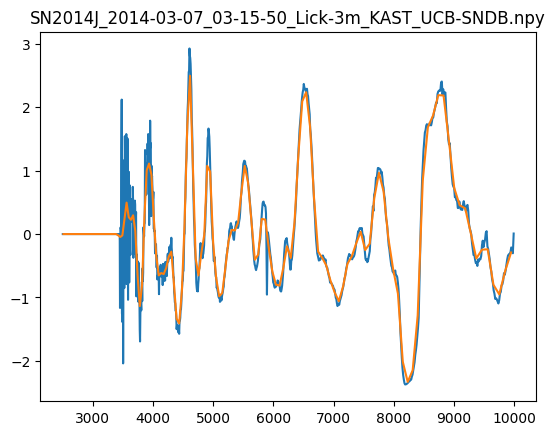

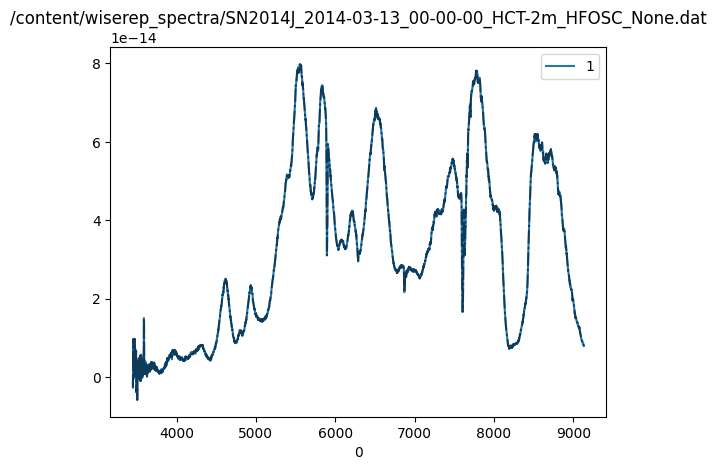

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([-0.13380978, -0.13380978, -0.13380978, ...,  0.39264108,
        0.39264108,  0.39264108]), 'fnorm': array([0.        , 0.        , 0.        , ..., 1.1307379 , 1.18633498,
       0.        ]), 'fmean': np.float64(2.0140531160313155e-14), 'nknot': 10}
0.01856082588175467
success:  /content/wiserep_spectra/SN2014J_2014-03-13_00-00-00_HCT-2m_HFOSC_None.dat 2014j
name 2014j
2014-03-13
56729.0
/content/wiserep_spectra/SN2015F_2015-03-19_01-12-24_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2,3
0,3340.3716,1.220127e-14,2.309400e-16,-3.839278e-16
1,3344.4526,1.171556e-14,2.239941e-16,-1.474127e-16
2,3348.5340,1.172177e-14,2.197956e-16,-1.335918e-16
3,3352.6150,1.130566e-14,2.135189e-16,2.848769e-17
4,3356.6960,1.123245e-14,2.083231e-16,-3.206017e-17


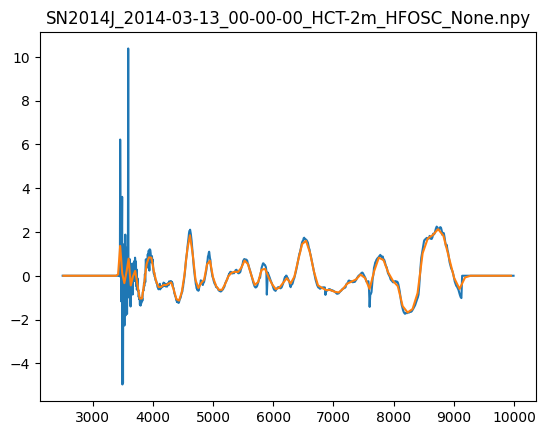

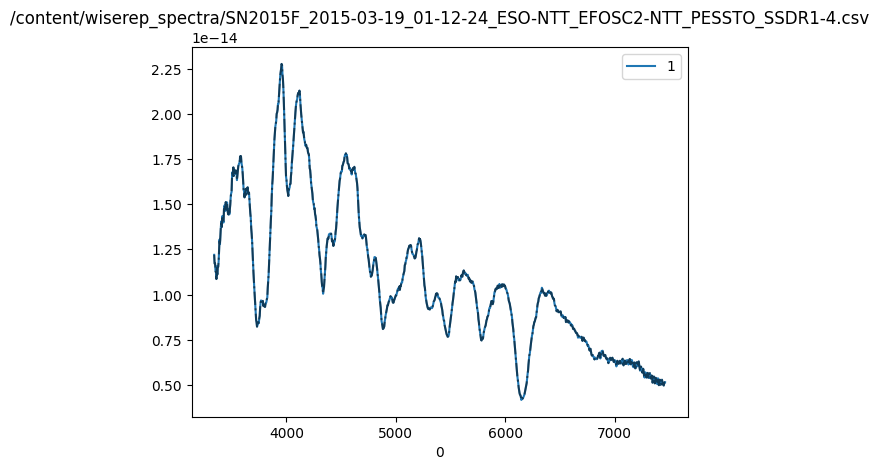

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([1.17964679, 1.17964679, 1.17964679, ..., 0.49830631, 0.49830631,
       0.49830631]), 'fnorm': array([0.        , 0.00279761, 0.00266714, ..., 0.190391  , 0.19781388,
       0.        ]), 'fmean': np.float64(1.0343153683644856e-14), 'nknot': 13}
0.004405642804367934
success:  /content/wiserep_spectra/SN2015F_2015-03-19_01-12-24_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv 2015f
name 2015f
2015-03-19
57100.0
/content/wiserep_spectra/SN2015F_2015-03-20_23-52-27_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2,3
0,3343.2695,2.562459e-14,5.318286e-16,1.254766e-15
1,3347.3506,2.477045e-14,5.149023e-16,1.267002e-15
2,3351.4320,2.604008e-14,5.098681e-16,7.478165e-16
3,3355.5130,2.357858e-14,4.865637e-16,1.322043e-15
4,3359.5940,2.415034e-14,4.779973e-16,9.651432e-16


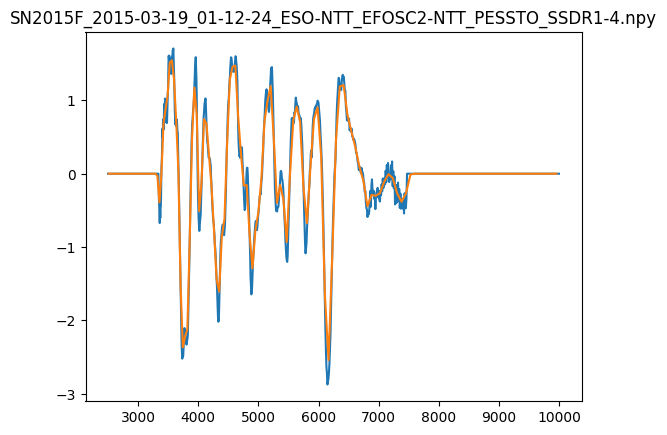

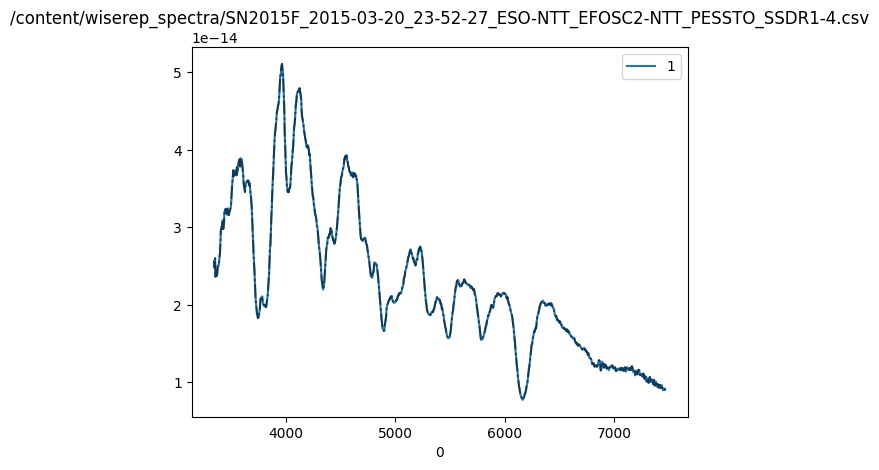

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([1.18828143, 1.18828143, 1.18828143, ..., 0.42452766, 0.42452766,
       0.42452766]), 'fnorm': array([0.        , 0.04146316, 0.03979025, ..., 0.1945998 , 0.20224472,
       0.        ]), 'fmean': np.float64(2.156441600495356e-14), 'nknot': 13}
0.00468227838103742
success:  /content/wiserep_spectra/SN2015F_2015-03-20_23-52-27_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv 2015f
name 2015f
2015-03-20
57101.0
/content/wiserep_spectra/SN2015F_2015-03-28_02-40-05_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2,3
0,3340.8735,5.509119e-15,2.446370e-16,4.536580e-16
1,3344.9548,5.771366e-15,2.412317e-16,5.373082e-16
2,3349.0361,5.545489e-15,2.357588e-16,8.848317e-16
3,3353.1174,5.600882e-15,2.290696e-16,6.556114e-16
4,3357.1987,5.314103e-15,2.212841e-16,6.756747e-16


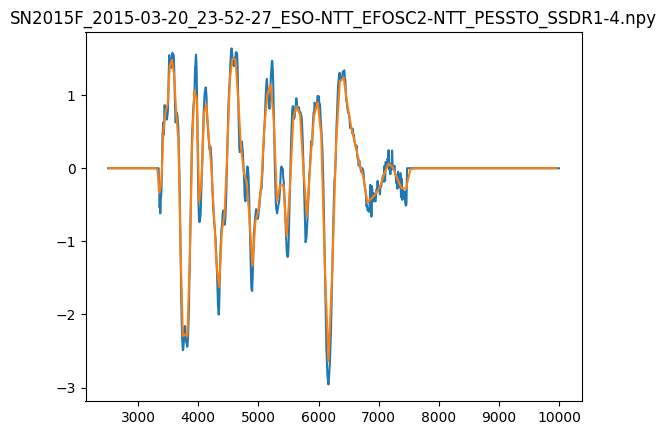

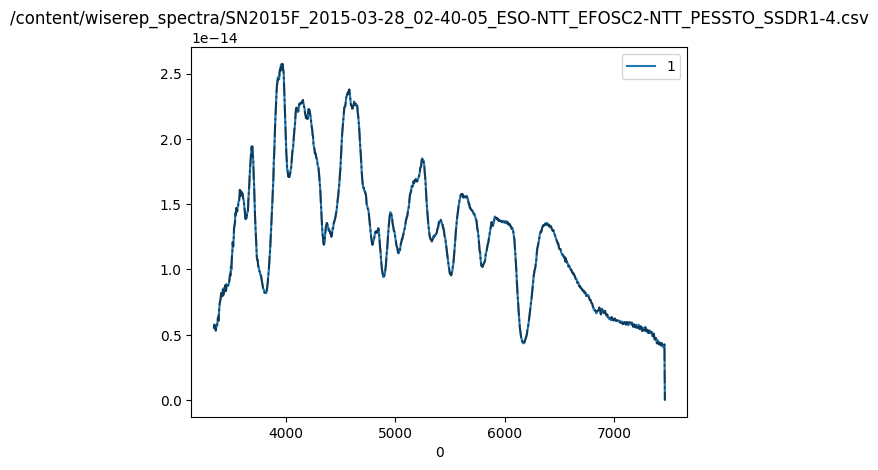

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.62766002, 0.62766002, 0.62766002, ..., 0.        , 0.        ,
       0.        ]), 'fnorm': array([0.        , 0.39078879, 0.37286118, ..., 0.        , 0.        ,
       0.        ]), 'fmean': np.float64(8.777234505267093e-15), 'nknot': 11}
0.005786462272481286
success:  /content/wiserep_spectra/SN2015F_2015-03-28_02-40-05_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv 2015f
name 2015f
2015-03-28
57109.0
/content/wiserep_spectra/SN2015F_2015-04-11_03-01-13_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1,2,3
0,3340.7056,1.292810e-15,2.118035e-16,5.545749e-16
1,3344.7864,1.245350e-15,1.915523e-16,6.595072e-16
2,3348.8672,8.525036e-16,1.806765e-16,8.892536e-16
3,3352.9482,8.993296e-16,1.722005e-16,7.940751e-16
4,3357.0290,7.069585e-16,1.612268e-16,7.030339e-16


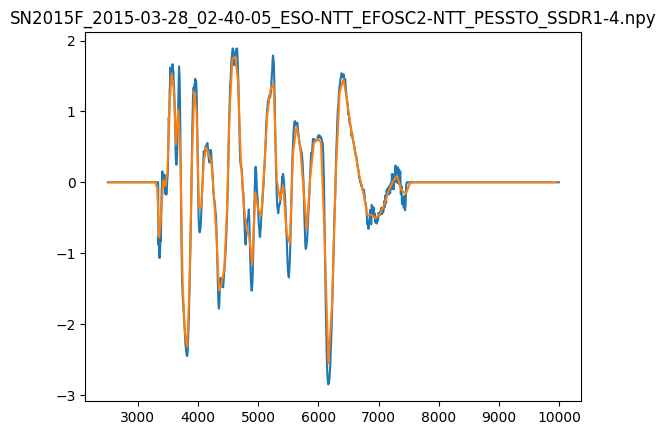

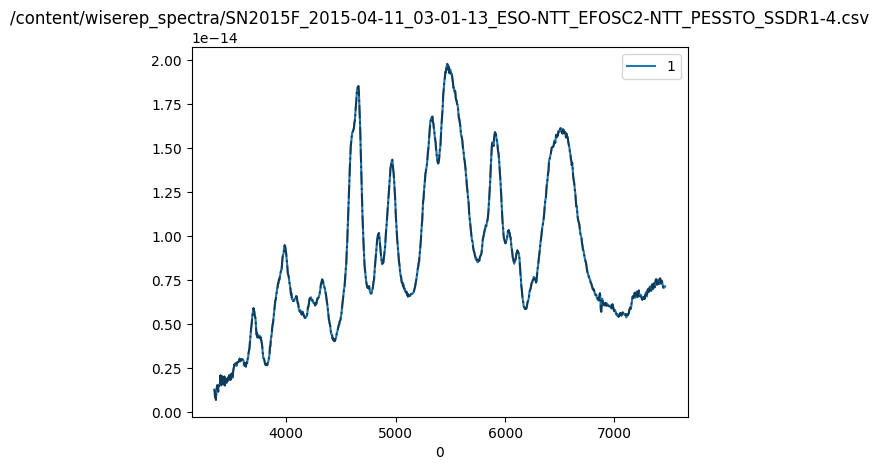

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([0.19396256, 0.19396256, 0.19396256, ..., 1.0744744 , 1.0744744 ,
       1.0744744 ]), 'fnorm': array([0.        , 0.50679467, 0.48280312, ..., 0.20158554, 0.20939246,
       0.        ]), 'fmean': np.float64(6.665257946228222e-15), 'nknot': 13}
0.005049371271018158
success:  /content/wiserep_spectra/SN2015F_2015-04-11_03-01-13_ESO-NTT_EFOSC2-NTT_PESSTO_SSDR1-4.csv 2015f
name 2015f
2015-04-11
57123.0
/content/wiserep_spectra/SN2023ehl_2023-03-31_00-00-00_NOT_ALFOSC_TNS.txt






/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


,0,1
0,3800.000000,2.428006e-15
1,3803.383214,2.335652e-15
2,3806.766428,2.431182e-15
3,3810.149642,3.000484e-15
4,3813.532856,2.726356e-15


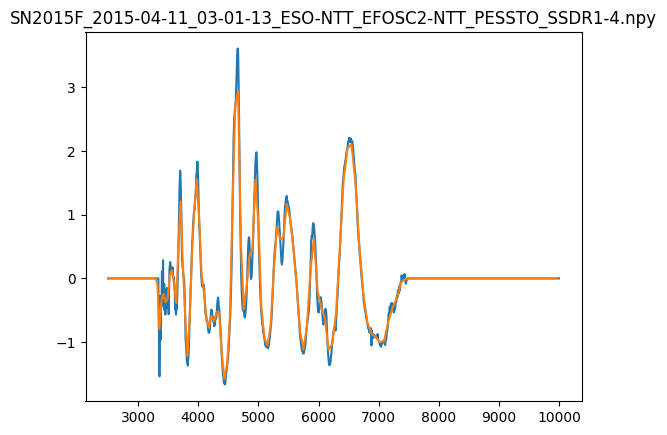

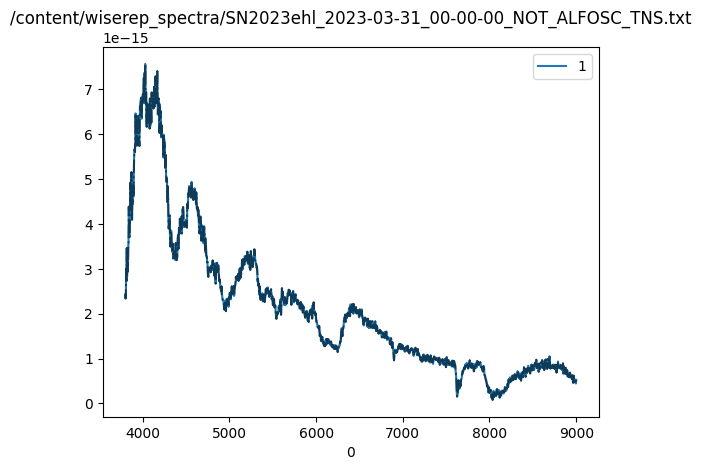

READ IN OK
meanzero
processed
{'wlog': array([ 2500.        ,  2503.38679973,  2506.77818763, ...,
        9972.96056085,  9986.47112891, 10000.        ]), 'flog': array([1.04676507, 1.04676507, 1.04676507, ..., 0.22667844, 0.22667844,
       0.22667844]), 'fnorm': array([ 0.        , -0.14858808, -0.14323392, ...,  0.20419181,
        0.21164893,  0.        ]), 'fmean': np.float64(2.319532882460209e-15), 'nknot': 13}
0.0020746338149904824
success:  /content/wiserep_spectra/SN2023ehl_2023-03-31_00-00-00_NOT_ALFOSC_TNS.txt 2023ehl
name 2023ehl
2023-03-31
60034.0
/content/wiserep_spectra/sn2017cfd_2017-04-05_08-44-09_Lick-3m_KAST_UCB-SNDB.flm




/content/wiserep_spectra/sn2017cfd_2017-05-04_06-50-24_Lick-3m_KAST_UCB-SNDB.flm




/content/wiserep_spectra/sn2017cfd_2017-05-20_05-08-09_Lick-3m_KAST_UCB-SNDB.flm




/content/wiserep_spectra/sn2017cfd_2017-06-02_05-11-02_Lick-3m_KAST_UCB-SNDB.flm




/content/wiserep_spectra/wiserep_spectra.csv




/content/wiserep_spectra/wiserep_spectra.cs

/tmp/ipython-input-2086834829.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  s = pd.read_csv(filename, sep=sep, header=None, comment="#")


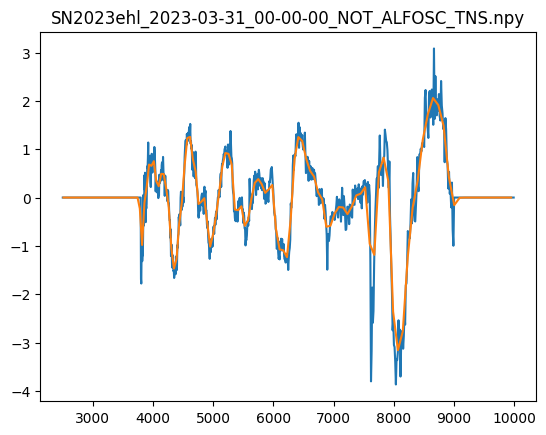

In [230]:
Xall = []
snnames = []
sninfo = []
dates = []
phases = []
for filename in filenames:
  print(filename)
  print("\n\n\n")
  if "cfd" in filename:
    continue
  # replace spaces with tabs
  inputFile = open(filename, "r")
  exportFile = open("tmp", "w")
  for line in inputFile:
    new_line = line#.replace('\t', ' ')
    if filename.endswith(".csv"):
      new_line = new_line.replace(',', ' ')
    if line and line[0].isupper():
      new_line = "#" + new_line
    new_line = new_line.lstrip()
    exportFile.write(new_line)

  inputFile.close()
  exportFile.close()
  os.system(f"mv tmp {filename}")


  from pathlib import Path
  filepath = Path(filename)
  lines = filepath.read_text().splitlines()
  filtered = [
        line
        for line in lines
        if line.strip()
    ]
  filepath.write_text('\n'.join(filtered))
  #if 1:
  try:
    #time.sleep(1)
    sep = "\s+|\t+|\s+\t+|\t+\s+"
    s = pd.read_csv(filename, sep=sep, header=None, comment="#")
    display(s.head())
    sp = lw.read_spectrum(filename, s.iloc[0,0], s.iloc[-1,0]#, 10000#3249,  9299#, 0.012
    )
    s.plot(x=0, y=1)
    plt.title(filename)
    plt.plot(sp[0], sp[1], 'k-.', alpha=0.5)
    plt.show()
    print("READ IN OK")

    #lw.mean_zero = meanzero
    processedsn = lw.process_spectrum(filename, s.iloc[0,0], s.iloc[-1,0])
    print("processed")
    print(processedsn)
    wlog0 = processedsn["wlog"][0:-1] + np.diff(processedsn["wlog"]) / 2
    flog = processedsn["fnorm"]
    print(flog.mean())
    select = (wlog0 < s.iloc[0,0]) | (wlog0 > s.iloc[-1,0])
    flog = (flog - flog[~select].mean()) / flog[~select].std()
    flog[select] = 0

    spd = degrade_spectrum(100,
        wlog0,
        flog
        )
    savedfilename = filename.split("/")[-1].split('.')[0] + ".npy"

    plt.plot(wlog0, flog)
    plt.title(savedfilename)
    plt.plot(spd[1], spd[2])


    X = np.array([spd[2]])
    Xall.append(X.reshape(1,X.shape[1]))
    snname = filename.split("/")[-1].split("_")[0].lower().replace("sn","")
    print("success: ", filename, snname)
    snnames.append(snname)
    print("name", snnames[-1])
    if "_20" in filename:
      date = filename.split("/")[-1].split("_")[1][:10]
      print(date)
    else:
      date = None
    from astropy.time import Time
    t = Time(f'{date} 00:00:00', scale='utc', format='iso')
    print(t.mjd)
    dates.append(t.mjd)
    if snname in peakmjds:
      phases.append(t.mjd - peakmjds[snname])
    else:
      phases.append(np.nan)
    sninfo.append((snname, t, phases[-1], dates[-1],
                   filename.split("/")[-1].split("_")[1],
                   filename.split("/")[-1]))

  except :#(ParserError, NameError):
    print(filename, "FAILED")

Xall = np.array(Xall)

In [231]:
snnames, dates, sninfo

(['2019yvq',
  '2019yvq',
  '2020nlb',
  '2020nlb',
  '2020nlb',
  '2021aefx',
  '2021aefx',
  '2014j',
  '2014j',
  '2014j',
  '2015f',
  '2015f',
  '2015f',
  '2015f',
  '2023ehl'],
 [np.float64(58863.0),
  np.float64(58872.0),
  np.float64(59036.0),
  np.float64(59049.0),
  np.float64(59057.0),
  np.float64(59546.0),
  np.float64(59560.0),
  np.float64(56688.0),
  np.float64(56723.0),
  np.float64(56729.0),
  np.float64(57100.0),
  np.float64(57101.0),
  np.float64(57109.0),
  np.float64(57123.0),
  np.float64(60034.0)],
 [('2019yvq',
   <Time object: scale='utc' format='iso' value=2020-01-15 00:00:00.000>,
   np.float64(0.1900000000023283),
   np.float64(58863.0),
   '2020-01-15',
   '2019yvq_2020-01-15_09-09-01_P60_SEDM_ZTF.ascii'),
  ('2019yvq',
   <Time object: scale='utc' format='iso' value=2020-01-24 00:00:00.000>,
   np.float64(9.190000000002328),
   np.float64(58872.0),
   '2020-01-24',
   '2019yvq_2020-01-24_14-44-38_Keck1_LRIS_ZTF.ascii'),
  ('2020nlb',
   <Time object: sc

In [232]:
Xall.shape

(15, 1, 139)

In [233]:
assert len(Xall) == len(snnames) == len(sninfo) == len(phases)

# 3. Predict

1. `X` is your array of spectra to classify.
2. `P` is your array of output probabilities of each of the 10 classes.
3. `P_argmax` is your array of final predictions for each spectra in `X`. Class IDs defined from 0-10.
4. `P_IDs` is your array of final predictions for each spectra in `X`. Class IDs defined from 0-16.
5. `P_str` is the final SN subtype prediction for each spectra in `X`.

In [234]:
X = Xall.copy()
P = abcsn.predict(X, verbose=0)
P_argmax = np.argmax(P, axis=1)

In [235]:
P_IDs = [sn_10_to_17[prediction] for prediction in P_argmax]
P_str = [abcsn_config.SN_Stypes_int_to_str[prediction_id] for prediction_id in P_IDs]

In [236]:
P_IDs

[np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2)]

In [237]:
phases

[np.float64(0.1900000000023283),
 np.float64(9.190000000002328),
 np.float64(-7.0),
 np.float64(6.0),
 np.float64(14.0),
 np.float64(-0.5979999999981374),
 np.float64(13.402000000001863),
 np.float64(-1.639999999999418),
 np.float64(33.36000000000058),
 np.float64(39.36000000000058),
 np.float64(-6.44999999999709),
 np.float64(-5.44999999999709),
 np.float64(2.5500000000029104),
 np.float64(16.55000000000291),
 np.float64(-10.5)]

In [238]:
P_str

[np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-91T'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-91T'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-norm'),
 np.str_('Ia-91bg')]

In [255]:
list(zip(snnames, [f"{phase:.2f}" for phase in np.array(phases)],
 [f"Ia-norm & {pred}" for pred in P_str]))

[('2019yvq', '0.19', 'Ia-norm & Ia-norm'),
 ('2019yvq', '9.19', 'Ia-norm & Ia-norm'),
 ('2020nlb', '-7.00', 'Ia-norm & Ia-91T'),
 ('2020nlb', '6.00', 'Ia-norm & Ia-norm'),
 ('2020nlb', '14.00', 'Ia-norm & Ia-norm'),
 ('2021aefx', '-0.60', 'Ia-norm & Ia-91T'),
 ('2021aefx', '13.40', 'Ia-norm & Ia-norm'),
 ('2014j', '-1.64', 'Ia-norm & Ia-norm'),
 ('2014j', '33.36', 'Ia-norm & Ia-norm'),
 ('2014j', '39.36', 'Ia-norm & Ia-norm'),
 ('2015f', '-6.45', 'Ia-norm & Ia-norm'),
 ('2015f', '-5.45', 'Ia-norm & Ia-norm'),
 ('2015f', '2.55', 'Ia-norm & Ia-norm'),
 ('2015f', '16.55', 'Ia-norm & Ia-norm'),
 ('2023ehl', '-10.50', 'Ia-norm & Ia-91bg')]

2020nlb_2020-07-06.0_LCO2m_Spectral_None.txt


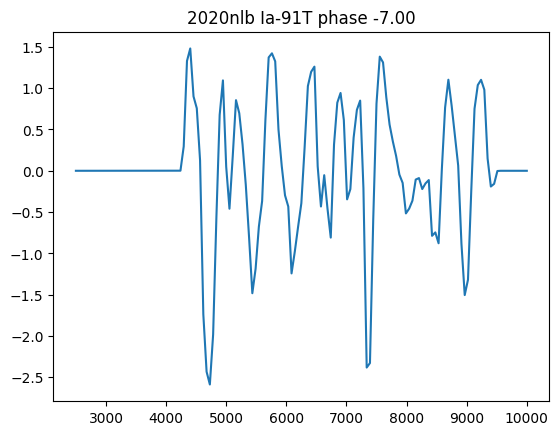

[3.7674576e-01 6.0169160e-01 2.0880197e-04 1.4253255e-03 8.1371062e-04
 4.6232389e-03 2.2840414e-03 8.4738126e-03 1.1663245e-03 2.5674277e-03]
2021aefx_2021-11-28.12_Gemini-S_GMOS-S_None.ascii


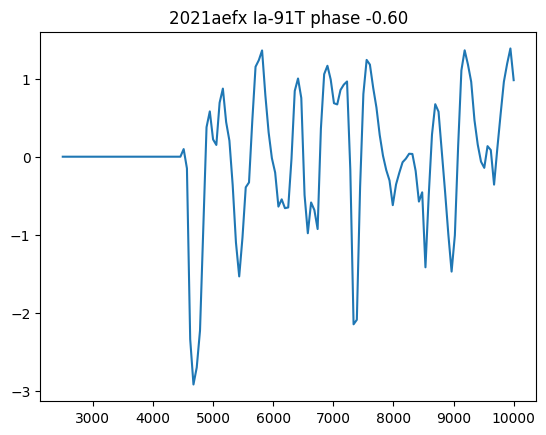

[1.5682393e-01 8.3774900e-01 6.5278058e-05 1.6849399e-04 1.4291269e-04
 4.4195360e-04 4.4411540e-04 3.0806984e-03 2.3583382e-04 8.4778044e-04]
SN2023ehl_2023-03-31_00-00-00_NOT_ALFOSC_TNS.txt


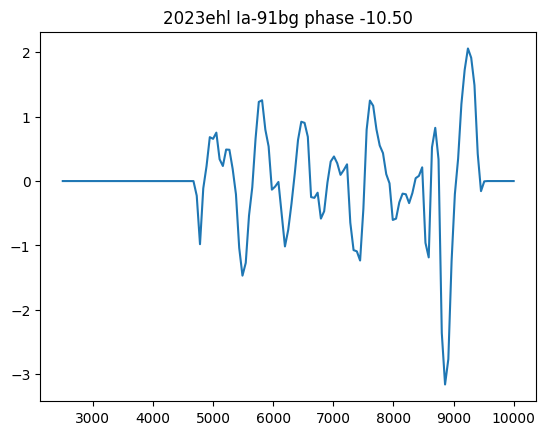

[1.9966520e-03 1.8051651e-05 9.9665654e-01 1.9977357e-05 1.2608690e-04
 1.3026275e-04 9.6251973e-04 5.9400067e-05 9.5508303e-06 2.0925729e-05]


In [251]:
for i,classification in enumerate(P_str):
  if not classification=='Ia-norm':
    if not "2017cfd" in np.array(snnames)[i][0]:
      print(np.array(sninfo)[i][-1])
      plt.plot(np.linspace(2_500, 10_000, len(X[i][0])), X[i][0])
      plt.title(np.array(snnames)[i] +  " " + classification + f" phase {np.array(phases)[i]:.2f}")
      plt.show()
      print(P[i])